In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

#define loss function
def loss(C,threshold,w,x,y):
    loss_part_1=np.dot(w.T,w)/2
    loss_part_2=0
    #get the volume of data
    data_volume=x.shape[0]
    #calculate loss for each record
    for i in range(data_volume):
        hinge=1-y[i]*(np.dot(x[i],w))
        if hinge>=0:
            loss_part_2+=hinge
    #calculate the total loss
    loss_all=(loss_part_1+C*loss_part_2)/data_volume
    return loss_all

#define gradient calculating function
def gradient(C,threshold,w,b,x,y):
    grad_w=np.zeros_like(w)
    grad_b=0
    #get the volume of data
    data_volume=x.shape[0]
    #calculate gradient for each record
    for i in range(data_volume):
        hinge=1-y[i]*(np.dot(x[i],w))
        #deal with uncontinuous gradient
        if hinge>=threshold:
            grad_w=grad_w-C*y[i]*x[i].T
            grad_b=grad_b-C*y[i]
    
    grad_w=grad_w+w
    return grad_w/data_volume,grad_b/data_volume

#define predict function
def predict(threshold,w,b,x):
    y_predict=np.dot(x,w)+b
    y_predict=y_predict.reshape((-1,1))
    #mark the sample whose predict scores greater than the threshold as positive, on the contrary as negative
    for yp in range(len(y_predict)):
        if(y_predict[yp]>=threshold):
            y_predict[yp]=1
        else:
            y_predict[yp]=-1
    
    return y_predict

#define accuracy function
def accuracy(threshold,w,b,x,y):
    #get the prediction result
    y_predict=predict(threshold,w,b,x)
    #use a counter to count the number of correct prediction
    correct_counter=0
    #compare the prediction result and the truth
    for i in range(len(y)):
        if y_predict[i]==y[i]:
            correct_counter=correct_counter+1
    
    #calculate the accuracy
    accuracy=correct_counter/len(y)
    return accuracy

#define loss graph drawing functioon
def show_graph():
    #log scale
    plt.yscale('log')
    #add label
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    #show legend
    plt.legend()
    #set title
    plt.title('Loss-Iterations Graph')
    plt.show()

#define RMSProp optimization method
def RMSProp_Optimazition(C,threshold,w,b,x_train,y_train,x_test,y_test,runs):
    #print a signal
    print('RMSProp')
    #set parameter
    learning_rate=0.005
    gama=0.9
    e=0.0000001
    #initialize medium variable
    G_w=0
    G_b=0
    #initialize container for loss
    test_losses=np.zeros(runs)    
    #optimize
    for i in range(runs):
        #generate random integer
        index=np.arange(5000)
        np.random.shuffle(index)
        #get a batch of stochastic training sample
        x_train_part=x_train[index]
        y_train_part=y_train[index]
        #calculate gradient
        grad_w,grad_b=gradient(C,threshold,w,b,x_train_part,y_train_part)
        G_w=gama*G_w+(1-gama)*np.dot(grad_w.T,grad_w)
        w=w-learning_rate/np.sqrt(G_w+e)*grad_w
        G_b=gama*G_b+(1-gama)*np.dot(grad_b.T,grad_b)
        b=b-learning_rate/np.sqrt(G_b+e)*grad_b
        #calculate the loss
        error=loss(C,threshold,w,x_test,y_test)
        #save the loss in container
        test_losses[i]=error
        #log every 100 epochs
        if(i%100==99):
            #calculate the accuracy
            accur=accuracy(threshold,w,b,x_test,y_test)
            print("epochs "+str(i+1)+" Accuracy: "+str(accur))
    #draw graph of loss
    x_axis=np.arange(runs)
    plt.plot(x_axis,test_losses,'r',label='RMSProp')
    return w,b

#define AdaDelta optimazation method
def AdaDelta_Optimization(C,threshold,w,b,x_train,y_train,x_test,y_test,runs):
    #print a signal
    print('AdaDelta')
    #set parameter
    gama=0.95
    e=0.00001
    #initialize medium variables
    G_w=0
    G_b=0
    delta_t_w=0
    delta_t_b=0
    #initialize container for loss
    test_losses=np.zeros(runs)
    #optimize
    for i in range(runs):
        #generate random integer
        index=np.arange(5000)
        np.random.shuffle(index)
        #get a batch of stochastic training sample
        x_train_part=x_train[index]
        y_train_part=y_train[index]
        #calculate gradient
        grad_w,grad_b=gradient(C,threshold,w,b,x_train_part,y_train_part)
        #update G
        G_w=gama*G_w+(1-gama)*np.dot(grad_w.T,grad_w)
        G_b=gama*G_b+(1-gama)*np.dot(grad_b.T,grad_b)
        #calculate step
        step_w=-np.sqrt(delta_t_w+e)/np.sqrt(G_w+e)*grad_w
        step_b=-np.sqrt(delta_t_b+e)/np.sqrt(G_b+e)*grad_b
        #update weight vector
        w=w+step_w
        b=b+step_b
        #update delta_t
        delta_t_w=gama*delta_t_w+(1-gama)*np.dot(step_w.T,step_w)
        delta_t_b=gama*delta_t_b+(1-gama)*np.dot(step_b.T,step_b)
        #calculate the loss
        error=loss(C,threshold,w,x_test,y_test)
        #save the loss in container
        test_losses[i]=error
        #log every 100 epochs
        if(i%100==99):
            #calculate the accuracy
            accur=accuracy(threshold,w,b,x_test,y_test)
            print("epochs "+str(i+1)+" Accuracy: "+str(accur))
    #draw graph of loss
    x_axis=np.arange(runs)
    plt.plot(x_axis,test_losses,'g',label='AdaDelta')
    return w,b
    
    

#define Adam optimization method
def Adam_Optimization(C,threshold,w,b,x_train,y_train,x_test,y_test,runs):
    #print a signal
    print('Adam')
    #set parameter
    belta=0.3
    gama=0.999
    learning_rate=0.2
    e=0.0000001
    #initialize medium variables
    m_w=np.zeros_like(w)
    m_b=0
    G_w=0
    G_b=0
    #initialize container for loss
    test_losses=np.zeros(runs)
    #oprimazation
    for i in range(runs):
        #generate random integer
        index=np.arange(5000)
        np.random.shuffle(index)
        #get a batch of stochastic training sample
        x_train_part=x_train[index]
        y_train_part=y_train[index]
        #calculate gradient
        grad_w,grad_b=gradient(C,threshold,w,b,x_train_part,y_train_part)
        #update m
        m_w=belta*m_w+(1-belta)*grad_w
        m_b=belta*m_b+(1-belta)*grad_b
        #update G
        G_w=gama*G_w+(1-gama)*np.dot(grad_w.T,grad_w)
        G_b=gama*G_b+(1-gama)*np.dot(grad_b.T,grad_b)
        #calculate alpha
        alpha=learning_rate*np.sqrt(1-pow(gama,i+1))/(1-pow(belta,i+1))
        #update weight vector
        w=w-alpha/(np.sqrt(G_w+e))*m_w
        b=b-alpha/(np.sqrt(G_b+e))*m_b
        #calculate the loss
        error=loss(C,threshold,w,x_test,y_test)
        #save the loss in container
        test_losses[i]=error
        #log every 100 epochs
        if(i%100==99):
            #calculate the accuracy
            accur=accuracy(threshold,w,b,x_test,y_test)
            print("epochs "+str(i+1)+" Accuracy: "+str(accur))
    #draw graph of loss
    x_axis=np.arange(runs)
    plt.plot(x_axis,test_losses,'y',label='Adam')
    return w,b
  
#define NAG optimization method
def NAG_Optimization(C,threshold,w,b,x_train,y_train,x_test,y_test,runs):
    #print a signal
    print('NAG')
    #set parameter
    gama=0.9
    learning_rate=0.01
    #initialize medium variables
    v_w=np.zeros_like(w)
    v_b=0
    #initialize container for loss
    test_losses=np.zeros(runs)
    #oprimize
    for i in range(runs):
        #generate random integer
        index=np.arange(5000)
        np.random.shuffle(index)
        #get a batch of stochastic training sample
        x_train_part=x_train[index]
        y_train_part=y_train[index]
        #calculate gradient
        grad_w,grad_b=gradient(C,threshold,w,b,x_train_part,y_train_part)
        grad_w=grad_w+gama*v_w
        grad_b=grad_b+gama*v_b
        #update v
        v_w=gama*v_w+learning_rate*grad_w
        v_b=gama*v_b+learning_rate*grad_b
        #update weight vector
        w=w-v_w
        b=b-v_b
        #calculate the loss
        error=loss(C,threshold,w,x_test,y_test)
        #save the loss in container
        test_losses[i]=error
        #log every 100 epochs
        if(i%100==99):
            #calculate the accuracy
            accur=accuracy(threshold,w,b,x_test,y_test)
            print("epochs "+str(i+1)+" Accuracy: "+str(accur))
    #draw graph of loss
    x_axis=np.arange(runs)
    plt.plot(x_axis,test_losses,'b',label='NAG')
    return w

#define Momentum optimization method
def Momentum_Optimization(C,threshold,w,b,x_train,y_train,x_test,y_test,runs):
    #print a signal
    print('Momentum')
    #set parameter
    gama=0.9
    learning_rate=0.02
    #initialize medium variables
    v_w=np.zeros_like(w)
    v_b=0
    #initialize container for loss
    test_losses=np.zeros(runs)
    #oprimize
    for i in range(runs):
        #generate random integer
        index=np.arange(5000)
        np.random.shuffle(index)
        #get a batch of stochastic training sample
        x_train_part=x_train[index]
        y_train_part=y_train[index]
        #calculate gradient
        grad_w,grad_b=gradient(C,threshold,w,b,x_train_part,y_train_part)
        #update v
        v_w=gama*v_w+learning_rate*grad_w
        #update weight vector
        w=w-v_w
        b=b-v_b
        #calculate the loss
        error=loss(C,threshold,w,x_test,y_test)
        #save the loss in container
        test_losses[i]=error
        #log every 100 epochs
        if(i%100==99):
            #calculate the accuracy
            accur=accuracy(threshold,w,b,x_test,y_test)
            print("epochs "+str(i+1)+" Accuracy: "+str(accur))
    #draw graph of loss
    x_axis=np.arange(runs)
    plt.plot(x_axis,test_losses,'c',label='Momentum') 


RMSProp
epochs 100 Accuracy: 0.7637737239727289
epochs 200 Accuracy: 0.7637737239727289
epochs 300 Accuracy: 0.7936858915300044
epochs 400 Accuracy: 0.8007493397211474
Adam
epochs 100 Accuracy: 0.8256249616116946
epochs 200 Accuracy: 0.8181929856888398
epochs 300 Accuracy: 0.8161660831644247
epochs 400 Accuracy: 0.8131564400221116
AdaDelta
epochs 100 Accuracy: 0.7637737239727289
epochs 200 Accuracy: 0.7637737239727289
epochs 300 Accuracy: 0.8009336035870033
epochs 400 Accuracy: 0.8179473005343653
NAG
epochs 100 Accuracy: 0.8224924758921442
epochs 200 Accuracy: 0.8381549044898962
epochs 300 Accuracy: 0.841901603095633
epochs 400 Accuracy: 0.8421472882501075
Momentum
epochs 100 Accuracy: 0.8420244456728703
epochs 200 Accuracy: 0.8452797739696579
epochs 300 Accuracy: 0.8466310423192679
epochs 400 Accuracy: 0.8470609913395983


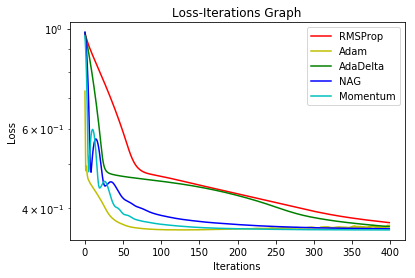

In [3]:
#load data
train_data=load_svmlight_file("a9a.txt")
test_data=load_svmlight_file("a9a.t",n_features=123)
#sperate features and labels
X_train,y_train=train_data[0],train_data[1]
X_test,y_test=test_data[0],test_data[1]
#change sparse martix to numpy array
X_train=X_train.toarray()
X_test=X_test.toarray()

#set parameter
C=1
threshold=0
epochs=400
#initialize parameters
w=np.zeros(X_train.shape[1])
b=0
#optimize by RMSProp algorithm
w1=RMSProp_Optimazition(C,threshold,w,b,X_train,y_train,X_test,y_test,epochs)
#optimize by Adam algorithm
w2=Adam_Optimization(C,threshold,w,b,X_train,y_train,X_test,y_test,epochs)
#optimize by AdaDelta algorithm
w3=AdaDelta_Optimization(C,threshold,w,b,X_train,y_train,X_test,y_test,epochs)
#optimize by AdaDelta algorithm
w4=NAG_Optimization(C,threshold,w,b,X_train,y_train,X_test,y_test,epochs)
#optimize by Momentum algorithm
w5=Momentum_Optimization(C,threshold,w,b,X_train,y_train,X_test,y_test,epochs)
#show loss graph
show_graph()
